In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lhereader import LHEReader

In [59]:
# Helper Functions

mag3 = lambda x: np.sqrt(np.sum(x**2))

def form_factor(mom_transf, Z=82, A=207):
    
    me = 0.511*10 ** -3
    
    a = 111. * Z ** (-1./3) / me
    ap = 773. * Z ** (-2./3) / me
    #t = -(mom_transf[0]**2 - mag3(mom_transf[1:])**2)
    #t = -(mom_transf[0]**2 - mag3(mom_transf[1:])**2)
    t = mag3(mom_transf[1:])**2

    d = 0.164 * A ** (-2./3)
    mup = 2.79
    mp = 0.931
    
    el = (a**2 * t / (1 + a**2 * t))**2 * Z **2 * (1./(1+t/d))**2
    
    inel = ( (ap**2 * t / (1 + ap**2 * t)) ** 2 * Z * 
             ( (1 + t * (mup**2 - 1) / (4 * mp **2 )) / (1 + t / 0.71)**4) ** 2 ) 
    
    return el + inel


def getUnweightedCrossSection(fname):
    """
    Reads the unweighted MC cross section from .lhe file
    """
    with open(fname) as f:
        s=f.read()
        ind = s.find('<crossSection unit="pb">')
        if ind == -1:
            return np.nan
        ind1=s.find("</crossSection>", ind)
        val = float(s[ind+24:ind1])
    return val

In [60]:
lhe_filename = "muonphillic/batch_results/scalar_bremmstrahlung-single.lhe"

In [69]:
#f = "/home/duncan/Software/madgraph3.2/bin/DARK_BREMMSTRAHLUNG_2/Events/run_01/unweighted_events.lhe"
f = "./muonphillic/batch_results/scalar_bremmstrahlung-single.lhe"

r = LHEReader(f)

cx0 = getUnweightedCrossSection(f)

E_S_frac = [];
mom_tr = [];
weights = [];
mom_tr_est = [];


nrej = 0
ntot = 0
for iev, event in enumerate(r):
    
    # The 5000001 and 5000002 pdg codes were custom labels for the model I made with feynrules

    for p in event.particles:
        if p.pdgid == 13 and p.status == 1:
            mu_out = np.array([p.energy, p.px, p.py, p.pz])
        if p.pdgid == 13 and p.status == -1:
            mu_in = np.array([p.energy, p.px, p.py, p.pz])
        if p.pdgid == 5000001:
            s0 = np.array([p.energy, p.px, p.py, p.pz])
        if p.pdgid == 5000002 and p.status == 1:
            n0 = np.array([p.energy, p.px, p.py, p.pz])
        if p.pdgid == 5000002 and p.status == -1:
            n_init = np.array([p.energy, p.px, p.py, p.pz])
    
    ntot += 1
    mom_transfer = s0 + mu_out - mu_in
    
    weights.append(form_factor(mom_transfer, Z=26, A=56))
    E_S_frac.append(s0[0]/mu_in[0])

weights = np.array(weights)

cx = sum(weights) / ntot * cx0 
print("Cross section after form factor weighting: %.3f" % cx)

Cross section after form factor weighting: 14.802


Text(0, 0.5, '$\\frac{1}{\\sigma} \\frac{d\\sigma}{dx}$')

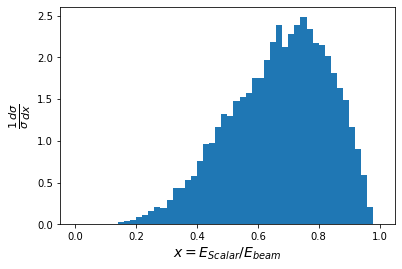

In [62]:
nbins = 50
c,b,_ = plt.hist(E_S_frac, bins=np.linspace(0,1,nbins+1), weights=weights/sum(weights)*50);
plt.xlabel("$x = E_{Scalar} / E_{beam}$", fontsize=14)
plt.ylabel(r"$\frac{1}{\sigma} \frac{d\sigma}{dx}$", fontsize=16)